In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
# import pandas as pd

# df = pd.read_excel('Superstore.xls')
headers=['Interval','Timestamp','Flume Depth (mm)','AV Flow (L/s)', 'Flume Flow (L/s)', 'Precipitation (mm)']
df = pd.read_csv ('sani_clean.csv', names=headers)#, index_col='Timestamp', parse_dates = True)
df=df[1:]

In [3]:
flow = df[['Timestamp','AV Flow (L/s)']]

In [4]:
flow['AV Flow (L/s)'] = flow['AV Flow (L/s)'].astype(float)
flow

,Timestamp,AV Flow (L/s)
1,2021-04-01 0:15,0.40
2,2021-04-01 0:30,0.24
3,2021-04-01 0:45,0.15
4,2021-04-01 1:00,0.17
5,2021-04-01 1:15,0.23
...,...,...
994,2021-04-11 8:30,0.66
995,2021-04-11 8:45,0.57
996,2021-04-11 9:00,0.42
997,2021-04-11 9:15,0.52


In [5]:
flow['Timestamp'] = pd.to_datetime(flow['Timestamp'])

In [6]:
y = flow.resample('H', on = 'Timestamp').mean()

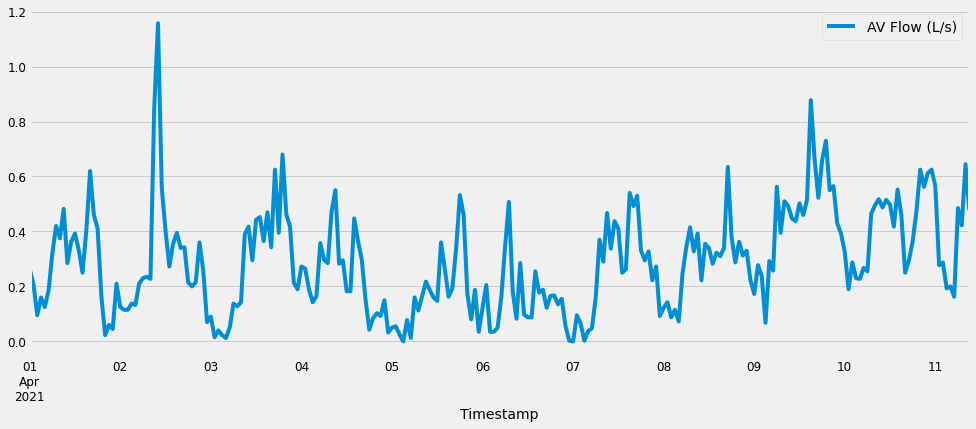

In [7]:
import matplotlib.pyplot as plt
y.plot(figsize=(15, 6))
plt.savefig("Arima_Decomposition.png")
plt.show()

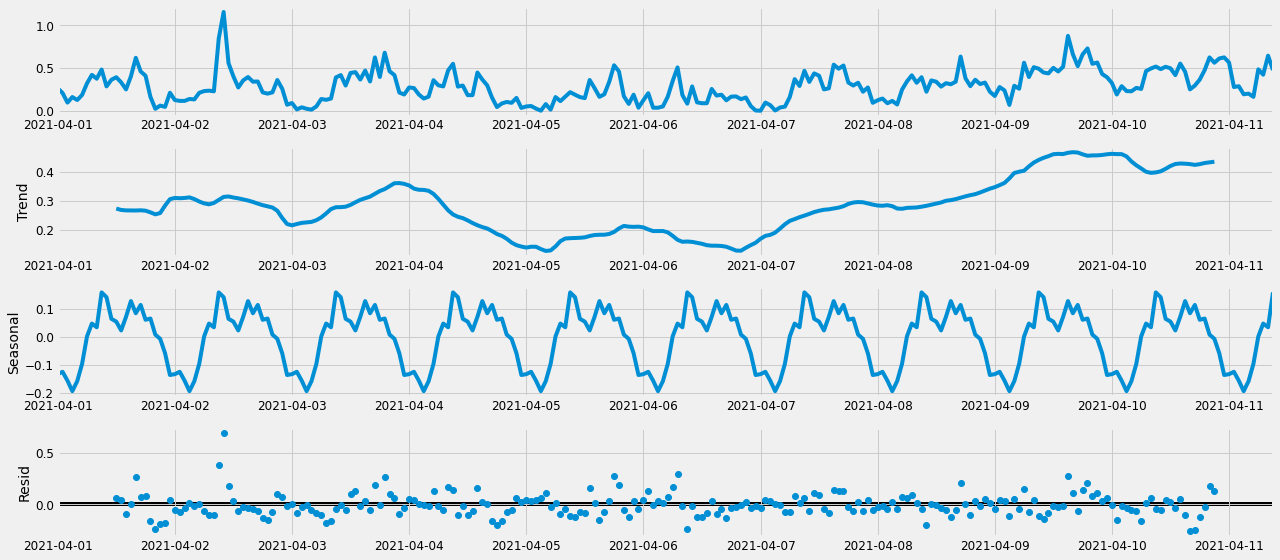

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.savefig("Stats_Decomposition.png")
plt.show()

In [10]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [11]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        
        except:
            continue
            
results = mod.fit(disp=0)

print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-248.06393168575363


In [12]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=False)
results = mod.fit(disp=0)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6783      0.038     17.903      0.000       0.604       0.753
ma.L1         -0.9650      0.028    -35.038      0.000      -1.019      -0.911
ar.S.L12      -0.0499      0.086     -0.577      0.564      -0.219       0.119
ma.S.L12      -1.1136      0.110    -10.107      0.000      -1.330      -0.898
sigma2         0.0130      0.002      5.992      0.000       0.009       0.017


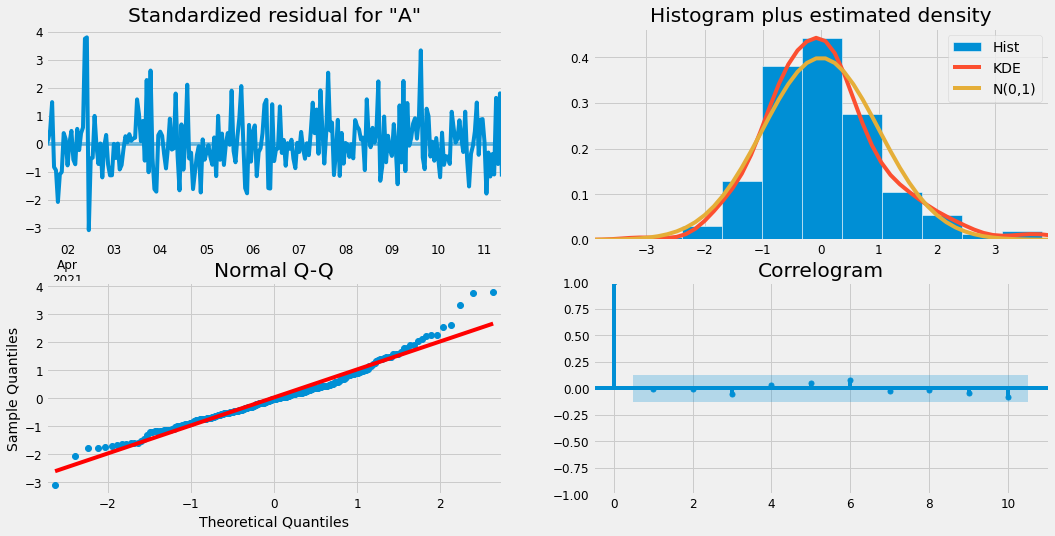

In [13]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

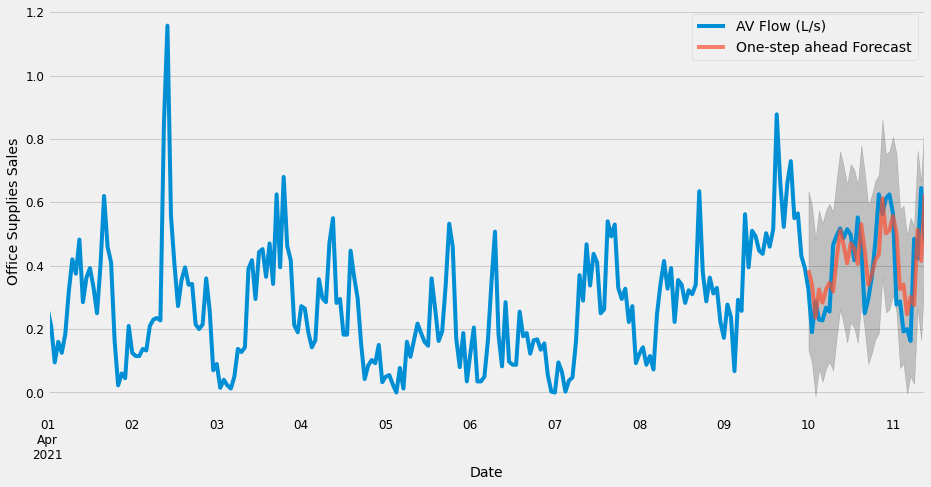

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2021-04-10'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2021-04':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Office Supplies Sales')
plt.legend()
plt.savefig("FB_Test.png")
plt.show()

In [16]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2021-04-10 00:00:00   NaN
2021-04-10 01:00:00   NaN
2021-04-10 02:00:00   NaN
2021-04-10 03:00:00   NaN
2021-04-10 04:00:00   NaN
2021-04-10 05:00:00   NaN
2021-04-10 06:00:00   NaN
2021-04-10 07:00:00   NaN
2021-04-10 08:00:00   NaN
2021-04-10 09:00:00   NaN
2021-04-10 10:00:00   NaN
2021-04-10 11:00:00   NaN
2021-04-10 12:00:00   NaN
2021-04-10 13:00:00   NaN
2021-04-10 14:00:00   NaN
2021-04-10 15:00:00   NaN
2021-04-10 16:00:00   NaN
2021-04-10 17:00:00   NaN
2021-04-10 18:00:00   NaN
2021-04-10 19:00:00   NaN
2021-04-10 20:00:00   NaN
2021-04-10 21:00:00   NaN
2021-04-10 22:00:00   NaN
2021-04-10 23:00:00   NaN
2021-04-11 00:00:00   NaN
2021-04-11 01:00:00   NaN
2021-04-11 02:00:00   NaN
2021-04-11 03:00:00   NaN
2021-04-11 04:00:00   NaN
2021-04-11 05:00:00   NaN
2021-04-11 06:00:00   NaN
2021-04-11 07:00:00   NaN
2021-04-11 08:00:00   NaN
2021-04-11 09:00:00   NaN
AV Flow (L/s)         NaN
dtype: float64


In [17]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 2021-04-10 00:00:00   NaN
2021-04-10 01:00:00   NaN
2021-04-10 02:00:00   NaN
2021-04-10 03:00:00   NaN
2021-04-10 04:00:00   NaN
2021-04-10 05:00:00   NaN
2021-04-10 06:00:00   NaN
2021-04-10 07:00:00   NaN
2021-04-10 08:00:00   NaN
2021-04-10 09:00:00   NaN
2021-04-10 10:00:00   NaN
2021-04-10 11:00:00   NaN
2021-04-10 12:00:00   NaN
2021-04-10 13:00:00   NaN
2021-04-10 14:00:00   NaN
2021-04-10 15:00:00   NaN
2021-04-10 16:00:00   NaN
2021-04-10 17:00:00   NaN
2021-04-10 18:00:00   NaN
2021-04-10 19:00:00   NaN
2021-04-10 20:00:00   NaN
2021-04-10 21:00:00   NaN
2021-04-10 22:00:00   NaN
2021-04-10 23:00:00   NaN
2021-04-11 00:00:00   NaN
2021-04-11 01:00:00   NaN
2021-04-11 02:00:00   NaN
2021-04-11 03:00:00   NaN
2021-04-11 04:00:00   NaN
2021-04-11 05:00:00   NaN
2021-04-11 06:00:00   NaN
2021-04-11 07:00:00   NaN
2021-04-11 08:00:00   NaN
2021-04-11 09:00:00   NaN
AV Flow (L/s)         NaN
dtype: float64


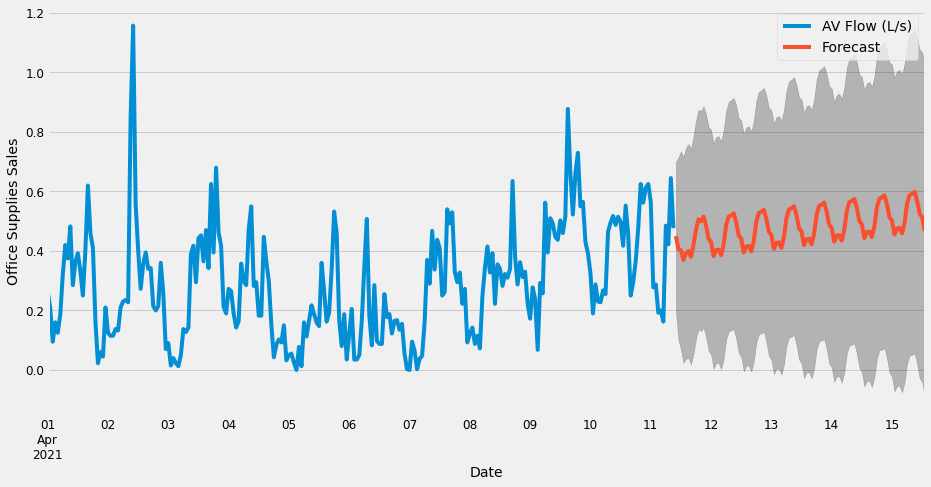

In [19]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Office Supplies Sales')
plt.legend()
plt.savefig("FB_Predict.png")
plt.show()